In [1]:
import functools

import numpy as np
import tensorflow as tf
import scipy
import scipy.linalg
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K

from sklearn.model_selection import train_test_split

In [2]:
reg = keras.regularizers.l1_l2(l1=1e-5, l2=1e-5)
reg = None

regularize = lambda f: functools.partial(f,
                           kernel_regularizer=reg,
                           bias_regularizer=reg,
                           kernel_initializer='he_normal',
                           bias_initializer='he_normal',)

Conv2D = regularize(layers.Conv2D)
Dense = regularize(layers.Dense)

In [3]:
# Load data.
images = np.load("images.npy")
labels = np.load("labels.npy")
print(images.shape, labels.shape)

(18000, 150, 150) (18000, 2)


In [67]:
# Preprocess data.
X = images.reshape(images.shape + (1,))

# Translate labels into one-hot encoding.
n = labels.shape[0]
hour_labels = labels[:,0]
minute_labels = labels[:,1]

# We actually encode half-hours to disambiguate 59/0 minutes later.
y_real = hour_labels * 60 + minute_labels
y_hours = np.zeros((n, 24))
y_hours[np.arange(n), 2 * y_real // 60] = 1
y_minutes = np.zeros((n, 60))
y_minutes[np.arange(n), minute_labels] = 1
y = np.column_stack([y_hours, y_minutes])

def split_hours_minutes(y):
    return y[...,:24], y[...,24:]

# Reverse transform.
def decode_onehot(y, lib=np):
    y_hours, y_minutes = split_hours_minutes(y)
    half_hours = lib.argmax(y_hours, axis=1)
    minutes = lib.argmax(y_minutes, axis=1)
    hours = half_hours // 2
    second_half_hour = (half_hours - 2*hours) == 1
    if lib is np:
        hours += second_half_hour & (minutes <= 15)
        hours -= ~second_half_hour & (minutes >= 45)
    else:
        hours += lib.cast(second_half_hour & (minutes <= 15), 'int64')
        hours -= lib.cast(~second_half_hour & (minutes >= 45), 'int64')
    return (hours * 60 + minutes) % (12*60)

(X_train, X_test,
 y_train, y_test,
 y_real_train, y_real_test) = train_test_split(X, y, y_real, test_size=0.2, random_state=42)

def cyclic_error_minutes(true, pred, lib=np):
    M = 12*60
    err = lib.abs(true - pred) % M
    return lib.minimum(err, M - err)

In [68]:
# Define neural network architecture.
def norm_act_conv(x, filters, kernel_size, strides=(1, 1), activation=True, padding='same'):
    x = layers.BatchNormalization()(x)
    if activation: x = layers.ReLU()(x)
    x = Conv2D(filters, kernel_size, strides=strides, padding=padding)(x)
    return x

def residual_bottleneck_block_v2(input_tensor, filters, half_resolution):
    input_filters = input_tensor.shape[-1]
    downscale_strides = (2, 2) if half_resolution else (1, 1)
    
    y = input_tensor
    x = norm_act_conv(input_tensor,   filters, (1, 1))
    x = norm_act_conv(x,              filters, (3, 3), strides=downscale_strides)
    x = norm_act_conv(x,            4*filters, (1, 1))
    
    if x.shape[1:] != y.shape[1:]:
        y = Conv2D(4*filters, (1, 1), strides=downscale_strides)(y)

    return layers.ReLU()(layers.add([x, y]))

def resnet50_v2(input_tensor):
    x = layers.ZeroPadding2D(padding=(3, 3))(input_tensor)
    x = Conv2D(64, (7, 7),  strides=(2, 2), padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.ZeroPadding2D(padding=(1, 1))(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='valid')(x)
    for i in range(3): x = residual_bottleneck_block_v2(x, 64, False)
    for i in range(4): x = residual_bottleneck_block_v2(x, 128, i == 0)
    for i in range(6): x = residual_bottleneck_block_v2(x, 256, i == 0)
    for i in range(3): x = residual_bottleneck_block_v2(x, 512, i == 0)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def clocknet_classify(input_tensor):
    x = resnet50_v2(input_tensor)
    x = layers.GlobalAveragePooling2D()(x)
    x = Dense(1000)(x)
    x = layers.BatchNormalization()(x)
    resnet_out = layers.ReLU()(x)
    hours = Dense(24, name='hours_out', activation='softmax', kernel_regularizer=None, bias_regularizer=None)(resnet_out)
    minutes = Dense(60, name='minutes_out', activation='softmax', kernel_regularizer=None, bias_regularizer=None)(resnet_out)
    return hours, minutes

In [71]:
def cyclic_weighted_cross_entropy(n, weight):
    cce = keras.losses.CategoricalCrossentropy()
    circ = scipy.linalg.circulant(np.arange(n)).T
    cost_mat = np.minimum(circ, n - circ).astype('float32')
    
    def loss_func(y_true, y_pred):        
        y_pred_max_mat = K.one_hot(K.argmax(y_pred), num_classes=y_pred.shape[1])
        actual_error = K.sum((y_true @ cost_mat) * y_pred_max_mat, -1)
        expected_error = K.sum((y_true @ cost_mat) * y_pred, -1)
        sample_weight = 1 + expected_error
        return K.mean(K.categorical_crossentropy(y_true, y_pred) * sample_weight) * weight
        #return cce(y_true, y_pred, sample_weight=actual_error + 1) * weight
    
    return loss_func

def time_loss():
    hour_loss = cyclic_weighted_cross_entropy(24, 30)
    minute_loss = cyclic_weighted_cross_entropy(60, 1)
    def loss(y_true, y_pred):
        y_true_hours, y_true_minutes = split_hours_minutes(y_true)
        y_pred_hours, y_pred_minutes = split_hours_minutes(y_pred)
        return hour_loss(y_true_hours, y_pred_hours) + minute_loss(y_true_minutes, y_pred_minutes)
    return loss

def hour_accuracy(y_true, y_pred):
    y_true_hours, y_true_minutes = split_hours_minutes(y_true)
    y_pred_hours, y_pred_minutes = split_hours_minutes(y_pred)
    return keras.metrics.categorical_accuracy(y_true_hours, y_pred_hours)

def minute_accuracy(y_true, y_pred):
    y_true_hours, y_true_minutes = split_hours_minutes(y_true)
    y_pred_hours, y_pred_minutes = split_hours_minutes(y_pred)
    return keras.metrics.categorical_accuracy(y_true_minutes, y_pred_minutes)

def real_time_error(y_true, y_pred):
    true_time = decode_onehot(y_true, lib=K)
    pred_time = decode_onehot(y_pred, lib=K)
    return K.mean(cyclic_error_minutes(true_time, pred_time, lib=K))

def create_model():
    inp = layers.Input((150, 150, 1))
    cnh, cnm = clocknet_classify(inp)
    out = layers.concatenate([cnh, cnm], name='time')
    model = keras.Model(inputs=inp, outputs=out)
    return model


model = create_model()
model.compile(loss=time_loss(), optimizer='adam', metrics=[hour_accuracy, minute_accuracy, real_time_error])

In [7]:
filepath = "models/model-{epoch:02d}.hdf5"
csv_logger = keras.callbacks.CSVLogger('training.log')
checkpoint = keras.callbacks.ModelCheckpoint(filepath, verbose=1, save_best_only=False)

hist = model.fit(X_train,
                 y_train,
                 validation_data=(X_test, y_test),
                 callbacks=[csv_logger, checkpoint],
                 batch_size=16, verbose=True, epochs=250)


Train on 14400 samples, validate on 3600 samples
Epoch 1/250
14384/14400 [============================>.] - ETA: 0s - loss: 614.1225 - hour_accuracy: 0.1177 - minute_accuracy: 0.0286 - real_time_error: 128.4939
Epoch 00001: saving model to models/model-01.hdf5
14400/14400 [==============================] - 121s 8ms/sample - loss: 613.8629 - hour_accuracy: 0.1179 - minute_accuracy: 0.0286 - real_time_error: 128.4256 - val_loss: 487.7188 - val_hour_accuracy: 0.1581 - val_minute_accuracy: 0.0322 - val_real_time_error: 87.7067
Epoch 2/250
14384/14400 [============================>.] - ETA: 0s - loss: 316.2653 - hour_accuracy: 0.3028 - minute_accuracy: 0.0393 - real_time_error: 67.3504
Epoch 00002: saving model to models/model-02.hdf5
14400/14400 [==============================] - 115s 8ms/sample - loss: 316.2642 - hour_accuracy: 0.3028 - minute_accuracy: 0.0393 - real_time_error: 67.3533 - val_loss: 739.0865 - val_hour_accuracy: 0.1275 - val_minute_accuracy: 0.0261 - val_real_time_error: 1

14384/14400 [============================>.] - ETA: 0s - loss: 13.8664 - hour_accuracy: 0.9574 - minute_accuracy: 0.2795 - real_time_error: 1.9655
Epoch 00018: saving model to models/model-18.hdf5
14400/14400 [==============================] - 113s 8ms/sample - loss: 13.8573 - hour_accuracy: 0.9574 - minute_accuracy: 0.2798 - real_time_error: 1.9633 - val_loss: 8.2125 - val_hour_accuracy: 0.9753 - val_minute_accuracy: 0.3008 - val_real_time_error: 0.6889
Epoch 19/250
14384/14400 [============================>.] - ETA: 0s - loss: 12.9566 - hour_accuracy: 0.9643 - minute_accuracy: 0.3027 - real_time_error: 1.5284
Epoch 00019: saving model to models/model-19.hdf5
14400/14400 [==============================] - 112s 8ms/sample - loss: 13.0117 - hour_accuracy: 0.9642 - minute_accuracy: 0.3026 - real_time_error: 1.5344 - val_loss: 3099.0395 - val_hour_accuracy: 0.0339 - val_minute_accuracy: 0.0183 - val_real_time_error: 179.1378
Epoch 20/250
14384/14400 [============================>.] - ETA:

14400/14400 [==============================] - 112s 8ms/sample - loss: 4.9725 - hour_accuracy: 0.9900 - minute_accuracy: 0.4146 - real_time_error: 0.2944 - val_loss: 11.0906 - val_hour_accuracy: 0.9700 - val_minute_accuracy: 0.3089 - val_real_time_error: 0.9289
Epoch 36/250
14384/14400 [============================>.] - ETA: 0s - loss: 3.9203 - hour_accuracy: 0.9937 - minute_accuracy: 0.4504 - real_time_error: 0.1724
Epoch 00036: saving model to models/model-36.hdf5
14400/14400 [==============================] - 112s 8ms/sample - loss: 3.9221 - hour_accuracy: 0.9937 - minute_accuracy: 0.4501 - real_time_error: 0.1722 - val_loss: 143.0840 - val_hour_accuracy: 0.6928 - val_minute_accuracy: 0.1503 - val_real_time_error: 18.9867
Epoch 37/250
14384/14400 [============================>.] - ETA: 0s - loss: 12.9431 - hour_accuracy: 0.9686 - minute_accuracy: 0.3721 - real_time_error: 1.9388
Epoch 00037: saving model to models/model-37.hdf5
14400/14400 [==============================] - 112s 8ms

Epoch 53/250
14384/14400 [============================>.] - ETA: 0s - loss: 9.1116 - hour_accuracy: 0.9791 - minute_accuracy: 0.4216 - real_time_error: 1.2937
Epoch 00053: saving model to models/model-53.hdf5
14400/14400 [==============================] - 112s 8ms/sample - loss: 9.1046 - hour_accuracy: 0.9791 - minute_accuracy: 0.4217 - real_time_error: 1.2922 - val_loss: 56.3298 - val_hour_accuracy: 0.8792 - val_minute_accuracy: 0.2506 - val_real_time_error: 7.9822
Epoch 54/250
14384/14400 [============================>.] - ETA: 0s - loss: 3.6125 - hour_accuracy: 0.9943 - minute_accuracy: 0.4789 - real_time_error: 0.2369
Epoch 00054: saving model to models/model-54.hdf5
14400/14400 [==============================] - 113s 8ms/sample - loss: 3.6134 - hour_accuracy: 0.9943 - minute_accuracy: 0.4788 - real_time_error: 0.2367 - val_loss: 71.9308 - val_hour_accuracy: 0.8342 - val_minute_accuracy: 0.1831 - val_real_time_error: 12.0089
Epoch 55/250
14384/14400 [============================>.]

14400/14400 [==============================] - 112s 8ms/sample - loss: 6.1319 - hour_accuracy: 0.9887 - minute_accuracy: 0.5556 - real_time_error: 0.7122 - val_loss: 303.6806 - val_hour_accuracy: 0.6092 - val_minute_accuracy: 0.1147 - val_real_time_error: 34.2578
Epoch 71/250
14384/14400 [============================>.] - ETA: 0s - loss: 2.9853 - hour_accuracy: 0.9960 - minute_accuracy: 0.5381 - real_time_error: 0.1891
Epoch 00071: saving model to models/model-71.hdf5
14400/14400 [==============================] - 112s 8ms/sample - loss: 2.9836 - hour_accuracy: 0.9960 - minute_accuracy: 0.5383 - real_time_error: 0.1889 - val_loss: 155.8178 - val_hour_accuracy: 0.6786 - val_minute_accuracy: 0.1167 - val_real_time_error: 26.0267
Epoch 72/250
14384/14400 [============================>.] - ETA: 0s - loss: 2.0114 - hour_accuracy: 0.9986 - minute_accuracy: 0.6034 - real_time_error: 0.0445
Epoch 00072: saving model to models/model-72.hdf5
14400/14400 [==============================] - 112s 8m

Epoch 88/250
14384/14400 [============================>.] - ETA: 0s - loss: 2.0333 - hour_accuracy: 0.9966 - minute_accuracy: 0.6739 - real_time_error: 0.1424
Epoch 00088: saving model to models/model-88.hdf5
14400/14400 [==============================] - 112s 8ms/sample - loss: 2.0345 - hour_accuracy: 0.9966 - minute_accuracy: 0.6739 - real_time_error: 0.1422 - val_loss: 18.2779 - val_hour_accuracy: 0.9536 - val_minute_accuracy: 0.3353 - val_real_time_error: 1.9778
Epoch 89/250
14384/14400 [============================>.] - ETA: 0s - loss: 2.1940 - hour_accuracy: 0.9965 - minute_accuracy: 0.6887 - real_time_error: 0.1190
Epoch 00089: saving model to models/model-89.hdf5
14400/14400 [==============================] - 112s 8ms/sample - loss: 2.1936 - hour_accuracy: 0.9965 - minute_accuracy: 0.6887 - real_time_error: 0.1189 - val_loss: 38.0794 - val_hour_accuracy: 0.9203 - val_minute_accuracy: 0.4164 - val_real_time_error: 5.2978
Epoch 90/250
14384/14400 [============================>.] 

14384/14400 [============================>.] - ETA: 0s - loss: 2.8394 - hour_accuracy: 0.9951 - minute_accuracy: 0.7316 - real_time_error: 0.3248
Epoch 00105: saving model to models/model-105.hdf5
14400/14400 [==============================] - 112s 8ms/sample - loss: 2.8384 - hour_accuracy: 0.9951 - minute_accuracy: 0.7314 - real_time_error: 0.3244 - val_loss: 656.8646 - val_hour_accuracy: 0.4364 - val_minute_accuracy: 0.1489 - val_real_time_error: 61.7867
Epoch 106/250
14384/14400 [============================>.] - ETA: 0s - loss: 2.1520 - hour_accuracy: 0.9964 - minute_accuracy: 0.7076 - real_time_error: 0.2058
Epoch 00106: saving model to models/model-106.hdf5
14400/14400 [==============================] - 112s 8ms/sample - loss: 2.1508 - hour_accuracy: 0.9964 - minute_accuracy: 0.7077 - real_time_error: 0.2056 - val_loss: 4.6087 - val_hour_accuracy: 0.9886 - val_minute_accuracy: 0.5733 - val_real_time_error: 0.3556
Epoch 107/250
14384/14400 [============================>.] - ETA: 0

14384/14400 [============================>.] - ETA: 0s - loss: 0.8476 - hour_accuracy: 0.9999 - minute_accuracy: 0.8286 - real_time_error: 0.0033
Epoch 00122: saving model to models/model-122.hdf5
14400/14400 [==============================] - 112s 8ms/sample - loss: 0.8482 - hour_accuracy: 0.9999 - minute_accuracy: 0.8285 - real_time_error: 0.0033 - val_loss: 2.2198 - val_hour_accuracy: 0.9961 - val_minute_accuracy: 0.7808 - val_real_time_error: 0.1067
Epoch 123/250
14384/14400 [============================>.] - ETA: 0s - loss: 1.8262 - hour_accuracy: 0.9956 - minute_accuracy: 0.7905 - real_time_error: 0.1424
Epoch 00123: saving model to models/model-123.hdf5
14400/14400 [==============================] - 112s 8ms/sample - loss: 1.8267 - hour_accuracy: 0.9956 - minute_accuracy: 0.7903 - real_time_error: 0.1422 - val_loss: 8.8181 - val_hour_accuracy: 0.9789 - val_minute_accuracy: 0.5956 - val_real_time_error: 0.8844
Epoch 124/250
14384/14400 [============================>.] - ETA: 0s -

14400/14400 [==============================] - 112s 8ms/sample - loss: 1.1733 - hour_accuracy: 0.9983 - minute_accuracy: 0.8299 - real_time_error: 0.0711 - val_loss: 1424.5301 - val_hour_accuracy: 0.2475 - val_minute_accuracy: 0.0950 - val_real_time_error: 102.0044
Epoch 140/250
14384/14400 [============================>.] - ETA: 0s - loss: 1.6906 - hour_accuracy: 0.9976 - minute_accuracy: 0.8120 - real_time_error: 0.1012
Epoch 00140: saving model to models/model-140.hdf5
14400/14400 [==============================] - 112s 8ms/sample - loss: 1.6894 - hour_accuracy: 0.9976 - minute_accuracy: 0.8120 - real_time_error: 0.1011 - val_loss: 3373.6063 - val_hour_accuracy: 0.0536 - val_minute_accuracy: 0.0194 - val_real_time_error: 176.2355
Epoch 141/250
14384/14400 [============================>.] - ETA: 0s - loss: 1.6913 - hour_accuracy: 0.9976 - minute_accuracy: 0.8053 - real_time_error: 0.1101
Epoch 00141: saving model to models/model-141.hdf5
14400/14400 [==============================] -

Epoch 157/250
14384/14400 [============================>.] - ETA: 0s - loss: 1.9784 - hour_accuracy: 0.9968 - minute_accuracy: 0.8242 - real_time_error: 0.2002
Epoch 00157: saving model to models/model-157.hdf5
14400/14400 [==============================] - 112s 8ms/sample - loss: 1.9781 - hour_accuracy: 0.9968 - minute_accuracy: 0.8242 - real_time_error: 0.2000 - val_loss: 48.6136 - val_hour_accuracy: 0.8967 - val_minute_accuracy: 0.4069 - val_real_time_error: 5.6444
Epoch 158/250
14384/14400 [============================>.] - ETA: 0s - loss: 2.8195 - hour_accuracy: 0.9959 - minute_accuracy: 0.7796 - real_time_error: 0.2380
Epoch 00158: saving model to models/model-158.hdf5
14400/14400 [==============================] - 112s 8ms/sample - loss: 2.8169 - hour_accuracy: 0.9959 - minute_accuracy: 0.7799 - real_time_error: 0.2378 - val_loss: 4.0040 - val_hour_accuracy: 0.9914 - val_minute_accuracy: 0.7208 - val_real_time_error: 0.2578
Epoch 159/250
14384/14400 [============================

14384/14400 [============================>.] - ETA: 0s - loss: 1.4032 - hour_accuracy: 0.9970 - minute_accuracy: 0.8830 - real_time_error: 0.1379
Epoch 00174: saving model to models/model-174.hdf5
14400/14400 [==============================] - 112s 8ms/sample - loss: 1.4036 - hour_accuracy: 0.9970 - minute_accuracy: 0.8828 - real_time_error: 0.1378 - val_loss: 480.8828 - val_hour_accuracy: 0.6044 - val_minute_accuracy: 0.3339 - val_real_time_error: 51.5111
Epoch 175/250
14384/14400 [============================>.] - ETA: 0s - loss: 3.0963 - hour_accuracy: 0.9949 - minute_accuracy: 0.7839 - real_time_error: 0.3626
Epoch 00175: saving model to models/model-175.hdf5
14400/14400 [==============================] - 112s 8ms/sample - loss: 3.0938 - hour_accuracy: 0.9949 - minute_accuracy: 0.7840 - real_time_error: 0.3622 - val_loss: 17.8480 - val_hour_accuracy: 0.9511 - val_minute_accuracy: 0.6089 - val_real_time_error: 2.7022
Epoch 176/250
14384/14400 [============================>.] - ETA: 

14384/14400 [============================>.] - ETA: 0s - loss: 0.9747 - hour_accuracy: 0.9990 - minute_accuracy: 0.8489 - real_time_error: 0.0423
Epoch 00191: saving model to models/model-191.hdf5
14400/14400 [==============================] - 112s 8ms/sample - loss: 0.9749 - hour_accuracy: 0.9990 - minute_accuracy: 0.8487 - real_time_error: 0.0422 - val_loss: 2.6491 - val_hour_accuracy: 0.9947 - val_minute_accuracy: 0.7897 - val_real_time_error: 0.1200
Epoch 192/250
14384/14400 [============================>.] - ETA: 0s - loss: 0.8283 - hour_accuracy: 0.9994 - minute_accuracy: 0.8716 - real_time_error: 0.0601
Epoch 00192: saving model to models/model-192.hdf5
14400/14400 [==============================] - 112s 8ms/sample - loss: 0.8280 - hour_accuracy: 0.9994 - minute_accuracy: 0.8715 - real_time_error: 0.0600 - val_loss: 2.0300 - val_hour_accuracy: 0.9969 - val_minute_accuracy: 0.8353 - val_real_time_error: 0.0667
Epoch 193/250
14384/14400 [============================>.] - ETA: 0s -

14384/14400 [============================>.] - ETA: 0s - loss: 0.5823 - hour_accuracy: 0.9989 - minute_accuracy: 0.9124 - real_time_error: 0.0311
Epoch 00208: saving model to models/model-208.hdf5
14400/14400 [==============================] - 112s 8ms/sample - loss: 0.5820 - hour_accuracy: 0.9989 - minute_accuracy: 0.9124 - real_time_error: 0.0311 - val_loss: 17.9612 - val_hour_accuracy: 0.9567 - val_minute_accuracy: 0.7800 - val_real_time_error: 1.6044
Epoch 209/250
14384/14400 [============================>.] - ETA: 0s - loss: 1.5722 - hour_accuracy: 0.9974 - minute_accuracy: 0.8685 - real_time_error: 0.1691
Epoch 00209: saving model to models/model-209.hdf5
14400/14400 [==============================] - 112s 8ms/sample - loss: 1.5710 - hour_accuracy: 0.9974 - minute_accuracy: 0.8685 - real_time_error: 0.1689 - val_loss: 2.2135 - val_hour_accuracy: 0.9950 - val_minute_accuracy: 0.8106 - val_real_time_error: 0.1067
Epoch 210/250
14384/14400 [============================>.] - ETA: 0s 

14384/14400 [============================>.] - ETA: 0s - loss: 1.4497 - hour_accuracy: 0.9966 - minute_accuracy: 0.8945 - real_time_error: 0.2102
Epoch 00225: saving model to models/model-225.hdf5
14400/14400 [==============================] - 112s 8ms/sample - loss: 1.4503 - hour_accuracy: 0.9966 - minute_accuracy: 0.8944 - real_time_error: 0.2100 - val_loss: 3052.9890 - val_hour_accuracy: 0.0717 - val_minute_accuracy: 0.0217 - val_real_time_error: 166.9156
Epoch 226/250
14384/14400 [============================>.] - ETA: 0s - loss: 0.6363 - hour_accuracy: 0.9990 - minute_accuracy: 0.8994 - real_time_error: 0.0356
Epoch 00226: saving model to models/model-226.hdf5
14400/14400 [==============================] - 112s 8ms/sample - loss: 0.6363 - hour_accuracy: 0.9990 - minute_accuracy: 0.8994 - real_time_error: 0.0356 - val_loss: 40.4877 - val_hour_accuracy: 0.9350 - val_minute_accuracy: 0.5375 - val_real_time_error: 4.2756
Epoch 227/250
14384/14400 [============================>.] - ETA

14384/14400 [============================>.] - ETA: 0s - loss: 0.3372 - hour_accuracy: 0.9997 - minute_accuracy: 0.9401 - real_time_error: 0.0000e+00
Epoch 00242: saving model to models/model-242.hdf5
14400/14400 [==============================] - 112s 8ms/sample - loss: 0.3369 - hour_accuracy: 0.9997 - minute_accuracy: 0.9401 - real_time_error: 0.0000e+00 - val_loss: 2.2862 - val_hour_accuracy: 0.9975 - val_minute_accuracy: 0.8656 - val_real_time_error: 0.0133
Epoch 243/250
14384/14400 [============================>.] - ETA: 0s - loss: 0.2840 - hour_accuracy: 0.9999 - minute_accuracy: 0.9488 - real_time_error: 0.0000e+00
Epoch 00243: saving model to models/model-243.hdf5
14400/14400 [==============================] - 112s 8ms/sample - loss: 0.2839 - hour_accuracy: 0.9999 - minute_accuracy: 0.9488 - real_time_error: 0.0000e+00 - val_loss: 2.3782 - val_hour_accuracy: 0.9975 - val_minute_accuracy: 0.8586 - val_real_time_error: 0.0267
Epoch 244/250
14384/14400 [===========================

In [50]:
pred = model.predict(X_train)
print(np.mean(real_time_error(y_train, pred)))
pred = model.predict(X_test)
print(np.mean(real_time_error(y_test, pred)))

51.98291666666667
55.1825


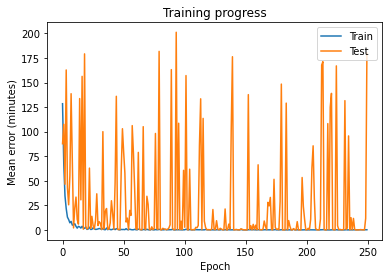

In [16]:
plt.plot(hist.history['real_time_error'])
plt.plot(hist.history['val_real_time_error'])
plt.title('Training progress')
plt.ylabel('Mean error (minutes)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.savefig('resnet_v2_adam_250epoch.pdf')
plt.show()

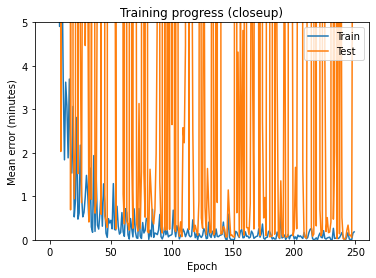

In [18]:
plt.plot(hist.history['real_time_error'])
plt.plot(hist.history['val_real_time_error'])
plt.title('Training progress (closeup)')
plt.ylabel('Mean error (minutes)')
plt.xlabel('Epoch')
plt.ylim(0,5)
plt.legend(['Train', 'Test'], loc='upper right')
plt.savefig('resnet_v2_adam_250epoch_closeup.pdf')
plt.show()

In [96]:
hist.history['val_real_time_error'][234]

95.64889

In [58]:
best_model = create_model()
best_model.load_weights('best_model.hdf5')

In [84]:
bad_model = create_model()
bad_model.load_weights('D:\study\models\model-235.hdf5')
pred = best_model.predict(X_test)
print(np.mean(real_time_error(y_test, pred)))

91.0


In [85]:
sgd = keras.optimizers.SGD(lr=1e-4, momentum=0.9)
bad_model.compile(loss=time_loss(), optimizer=sgd, metrics=[hour_accuracy, minute_accuracy, real_time_error])

In [86]:
bad_hist = bad_model.fit(X_train,
                     y_train,
                     validation_data=(X_test, y_test),
                     batch_size=16, verbose=True, epochs=10)

Train on 14400 samples, validate on 3600 samples
Epoch 1/10
14400/14400 [==============================] - 120s 8ms/sample - loss: 0.6810 - hour_accuracy: 0.9992 - minute_accuracy: 0.9161 - real_time_error: 0.0300 - val_loss: 3233.1955 - val_hour_accuracy: 0.0444 - val_minute_accuracy: 0.0156 - val_real_time_error: 175.9689
Epoch 2/10
14400/14400 [==============================] - 114s 8ms/sample - loss: 0.5426 - hour_accuracy: 0.9991 - minute_accuracy: 0.9172 - real_time_error: 0.0256 - val_loss: 1.9431 - val_hour_accuracy: 0.9981 - val_minute_accuracy: 0.8622 - val_real_time_error: 0.0178
Epoch 3/10
14400/14400 [==============================] - 115s 8ms/sample - loss: 0.4031 - hour_accuracy: 0.9997 - minute_accuracy: 0.9334 - real_time_error: 0.0167 - val_loss: 1.9333 - val_hour_accuracy: 0.9981 - val_minute_accuracy: 0.8653 - val_real_time_error: 0.0178
Epoch 4/10
14400/14400 [==============================] - 118s 8ms/sample - loss: 0.3452 - hour_accuracy: 0.9997 - minute_accuracy

In [87]:
bad_hist2 = bad_model.fit(X_train,
                      y_train,
                      validation_data=(X_test, y_test),
                      batch_size=16, verbose=True, epochs=10)

Train on 14400 samples, validate on 3600 samples
Epoch 1/10
14400/14400 [==============================] - 114s 8ms/sample - loss: 0.2792 - hour_accuracy: 0.9998 - minute_accuracy: 0.9470 - real_time_error: 0.0033 - val_loss: 1.8370 - val_hour_accuracy: 0.9975 - val_minute_accuracy: 0.8733 - val_real_time_error: 0.0178
Epoch 2/10
14400/14400 [==============================] - 114s 8ms/sample - loss: 0.2867 - hour_accuracy: 0.9997 - minute_accuracy: 0.9446 - real_time_error: 0.0067 - val_loss: 1.8516 - val_hour_accuracy: 0.9983 - val_minute_accuracy: 0.8725 - val_real_time_error: 0.0178
Epoch 3/10
14400/14400 [==============================] - 114s 8ms/sample - loss: 0.2583 - hour_accuracy: 0.9999 - minute_accuracy: 0.9465 - real_time_error: 0.0000e+00 - val_loss: 1.8329 - val_hour_accuracy: 0.9981 - val_minute_accuracy: 0.8750 - val_real_time_error: 0.0178
Epoch 4/10
14400/14400 [==============================] - 113s 8ms/sample - loss: 0.3042 - hour_accuracy: 0.9997 - minute_accuracy:

In [97]:
bad_model.save_weights('bad_model_made_good.hdf5')
with open('bad_model_made_good.json', 'w') as f:
    f.write(bad_model.to_json())

In [103]:
with open('bad_model_made_good.json') as f:
    loaded_model = tf.keras.models.model_from_json(f.read())
loaded_model.load_weights('bad_model_made_good.hdf5')

In [89]:
pred = bad_model.predict(X_train)
print(np.mean(real_time_error(y_train, pred)))
pred = bad_model.predict(X_test)
print(np.mean(real_time_error(y_test, pred)))

0.0
0.0
